# CARA: robust annotation and discovery of novel cell types in single-cell ATAC-seq data through cross-modal reference alignment
This notebook implements the CARA workflow for CITE-ASAP dataset including detection of a novel cell type. 

In [1]:
# Standard library imports
import os
import time as tm
import warnings

# Third-party imports
import numpy as np
import torch
import matplotlib.pyplot as plt
import anndata as ad
import pyro
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.optim import ExponentialLR

# Local imports
from util.util import *
from util.dataloader import *
from util.detection import *
from model.model import buildmodel

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

/home/yingwang/miniconda3/envs/cara/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yingwang/miniconda3/envs/cara/lib/python3.9/site-packages/llvmlite/binding/ffi.py:175: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


## Configuration

Set up hyperparameters and file paths. Modify these values according to your environment.

In [2]:
class Config:
    # Data Paths
    # Use relative paths for portability
    RNA_PATH = "/home/yingwang/data/cl/cite-asap/adata_rna_cache.h5ad"
    ATAC_PATH = "/home/yingwang/data/cl/cite-asap/adata_atac_cache.h5ad"
    OUTPUT_PATH = os.path.join("output", "pbmc2")
    PREFIX = "pbmc2_1127"
    
    # Model Hyperparameters
    HIDDEN_SIZE = 200
    NO_CLASS = 8        # Total number of classes
    
    # Training Hyperparameters
    SEED = 233
    LEARNING_RATE = 1e-4
    DECAY_RATE = 0.99
    BATCH_SIZE = 60
    WARMUP_EPOCHS = 60
    EPOCHS = 100
    PATIENCE = 50
    
    # Other settings
    USE_CUDA = True
    NUM_WORKERS = 0
    SAVE_MODEL = False
    
    # Pyro settings
    ENUM_DISCRETE = "parallel"
    CONFIG_ENUM = "parallel"

# Create output directory if it doesn't exist
os.makedirs(Config.OUTPUT_PATH, exist_ok=True)

# Set random seed for reproducibility
setup(Config.SEED)

# Check CUDA availability
cuda = Config.USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Preprocessing

Load RNA and ATAC data, preprocess, and align features.

In [3]:
labeled_rna_trainloader, test_rna_loader_all, labeled_atac_trainloader, unlabeled_atac_trainloader, atac_test_loader, index_to_category, batch_num, dataset, data = load_and_process_data(Config)

Loading ATAC data from /home/yingwang/data/cl/cite-asap/adata_atac_cache.h5ad...
Finding HVGs for RNA data...
Finding HVGs for ATAC data...

Number of RNA HVGs: 3000
Number of ATAC HVGs: 3000
Total number of unique HVGs in union: 5429

Converting RNA data to DataFrame for reshaping...
Converting ATAC data to DataFrame...

Aligning RNA data using reindex (filling missing genes with 0)...
Aligning ATAC data using reindex (filling missing genes with 0)...

Converting aligned DataFrames back to AnnData objects...

--- Verification ---
Final RNA data shape: (4644, 5429)
Final ATAC data shape: (4360, 5429)

Success! 'rna_final' and 'atac_final' now have identical and ordered features.
Data alignment complete.
DataLoaders created.


## Model Initialization

Initialize the CARA model and optimizer.

In [4]:
input_size_rna = dataset['rna_train_labeled_dataset'].data.shape[1]
input_size_atac = dataset['atac_train_labeled_dataset'].data.shape[1]
output_size_rna = Config.NO_CLASS

cara = buildmodel(
    output_size=output_size_rna,
    rna_input_size=input_size_rna,
    atac_input_size=input_size_atac,
    z_dim=Config.HIDDEN_SIZE, 
    hidden_layers=[500],
    batch_num=batch_num,
    use_cuda=cuda,
    config_enum=Config.ENUM_DISCRETE,
    use_class_weights=True,
    aux_loss_multiplier=50,
    alpha=0.001,
)

# Setup optimizer
adam_params = {'lr': Config.LEARNING_RATE, 'betas': (0.99, 0.999), 'weight_decay': 1e-4}
optimizer = torch.optim.Adam
scheduler = ExponentialLR({'optimizer': optimizer, 'optim_args': adam_params, 'gamma': Config.DECAY_RATE})

pyro.clear_param_store()

# Setup losses
guide = config_enumerate(cara.guide, Config.ENUM_DISCRETE, expand=True)
elbo = TraceEnum_ELBO(max_plate_nesting=1, strict_enumeration_warning=False)
loss_basic = SVI(cara.model, guide, scheduler, loss=elbo)

losses = [loss_basic]
aux_loss = True
if aux_loss:
    elbo_aux = Trace_ELBO()
    loss_aux = SVI(cara.model_classify, cara.guide_classify, scheduler, loss=elbo_aux)
    losses.append(loss_aux)

## Training


Starting RNA Warmup...
Epoch 1: Loss 5467.1758
Epoch 2: Loss 4910.4277
Epoch 3: Loss 4833.5712
Epoch 4: Loss 4793.9261
Epoch 5: Loss 4764.4572
Epoch 6: Loss 4743.5988
Epoch 7: Loss 4727.4084
Epoch 8: Loss 4712.1014
Epoch 9: Loss 4696.0827
Epoch 10: Loss 4687.5740
Epoch 11: Loss 4672.4089
Epoch 12: Loss 4660.4241
Epoch 13: Loss 4646.1690
Epoch 14: Loss 4633.2578
Epoch 15: Loss 4624.1757
Epoch 16: Loss 4613.0399
Epoch 17: Loss 4602.2014
Epoch 18: Loss 4594.0423
Epoch 19: Loss 4584.8808
Epoch 20: Loss 4574.4824
Epoch 21: Loss 4566.4872
Epoch 22: Loss 4559.9829
Epoch 23: Loss 4551.0337
Epoch 24: Loss 4544.1147
Epoch 25: Loss 4536.6126
Epoch 26: Loss 4529.2981
Epoch 27: Loss 4523.5422
Epoch 28: Loss 4518.3456
Epoch 29: Loss 4511.7437
Epoch 30: Loss 4505.5735
Epoch 31: Loss 4501.2819
Epoch 32: Loss 4496.8419
Epoch 33: Loss 4490.0357
Epoch 34: Loss 4486.5424
Epoch 35: Loss 4478.8564
Epoch 36: Loss 4475.2452
Epoch 37: Loss 4470.4694
Epoch 38: Loss 4465.1246
Epoch 39: Loss 4461.6038
Epoch 40: L

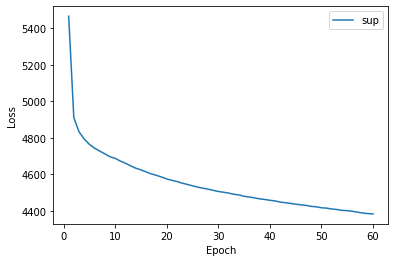

In [5]:
print("Starting RNA Warmup...")
cara.compute_initial_class_weights(labeled_rna_trainloader)

best_valid_acc = 0.0
tr_start = tm.time()
supplosses = []

for i in range(Config.WARMUP_EPOCHS):
    ep_tr_start = tm.time()
    sup_num = len(labeled_rna_trainloader.dataset)
    
    epoch_losses_sup = run_inference_for_epoch_warmup(labeled_rna_trainloader, losses, cuda)
    avg_epoch_losses_sup = [loss / sup_num for loss in epoch_losses_sup]
    supplosses.append(avg_epoch_losses_sup[0])
    
    # Validation
    validation_accuracy, validation_f1_macro, _, _, _, _, ARI, NMI = get_accuracy(
        test_rna_loader_all, cara.classifier
    )
    
    ep_tr_time = tm.time() - ep_tr_start
    print(f"Epoch {i+1}: Loss {avg_epoch_losses_sup[0]:.4f}")
    
    if validation_accuracy > best_valid_acc:
        best_valid_acc = validation_accuracy

print(f"RNA Warmup Done. Best Val Acc: {best_valid_acc:.4f}")

# Plot Loss
plt.figure()
plt.plot(range(1, len(supplosses) + 1), supplosses, label='sup')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [6]:
# Save pre train model
save_path = os.path.join(Config.OUTPUT_PATH, f"{Config.PREFIX}rna.pkl")
torch.save(cara.state_dict(), save_path)
print(f"Model saved to {save_path}")


Model saved to output/pbmc2/pbmc2_1127rna.pkl


In [7]:
# cara.load_state_dict(torch.load(save_path))

In [8]:
# Freeze classifier
freeze_classifier(cara)
cara.compute_initial_class_weights(labeled_atac_trainloader)

supplosses = []
best_valid_acc = 0.0

print("Starting ATAC Training...")
for i in range(Config.EPOCHS):
    ep_tr_start = tm.time()
    sup_num = len(labeled_atac_trainloader.dataset)
    unsup_num = len(unlabeled_atac_trainloader.dataset)
    
    epoch_losses_sup, epoch_losses_unsup = run_inference_for_epoch(
        losses, labeled_atac_trainloader, unlabeled_atac_trainloader, cuda
    )
    
    avg_loss_sup = epoch_losses_sup[0] / sup_num
    supplosses.append(avg_loss_sup)
    
    # Validation
    validation_accuracy, _, _, _, _, _, ARI, NMI = get_accuracy(
        atac_test_loader, cara.classifier
    )
    
    print(f"Epoch {i+1}: Loss {avg_loss_sup:.4f}")
    
    if validation_accuracy > best_valid_acc:
        best_valid_acc = validation_accuracy
        
print(f"ATAC Trainng Done. Best Val Acc: {best_valid_acc:.4f}")

Starting ATAC Training...
Epoch 1: Loss 29248.3822
Epoch 2: Loss 27672.8149
Epoch 3: Loss 27413.2442


Epoch 4: Loss 27259.3697
Epoch 5: Loss 27137.2495
Epoch 6: Loss 27046.6731
Epoch 7: Loss 26876.3332
Epoch 8: Loss 26810.8914
Epoch 9: Loss 26789.9992
Epoch 10: Loss 26685.2700
Epoch 11: Loss 26645.8990
Epoch 12: Loss 26540.8339
Epoch 13: Loss 26418.7031
Epoch 14: Loss 26400.9588
Epoch 15: Loss 26355.9460
Epoch 16: Loss 26266.1099
Epoch 17: Loss 26216.3020
Epoch 18: Loss 26183.0167
Epoch 19: Loss 26170.1392
Epoch 20: Loss 26129.3799
Epoch 21: Loss 26039.8985
Epoch 22: Loss 26006.0658
Epoch 23: Loss 25992.5853
Epoch 24: Loss 25948.1713
Epoch 25: Loss 25935.5136
Epoch 26: Loss 25892.5610
Epoch 27: Loss 25936.4399
Epoch 28: Loss 25860.1994
Epoch 29: Loss 25827.7685
Epoch 30: Loss 25741.4417
Epoch 31: Loss 25746.9442
Epoch 32: Loss 25788.5784
Epoch 33: Loss 25705.0352
Epoch 34: Loss 25598.9701
Epoch 35: Loss 25626.3687
Epoch 36: Loss 25590.3819
Epoch 37: Loss 25627.6217
Epoch 38: Loss 25565.1712
Epoch 39: Loss 25500.0014
Epoch 40: Loss 25499.0795
Epoch 41: Loss 25458.3456
Epoch 42: Loss 254

## Evaluation and Visualization

Visualize the results using UMAP.

In [9]:
# Save model
save_path = os.path.join(Config.OUTPUT_PATH, f"{Config.PREFIX}.pkl")
torch.save(cara.state_dict(), save_path)
print(f"Model saved to {save_path}")


Model saved to output/pbmc2/pbmc2_1127.pkl


In [10]:
# cara.load_state_dict(torch.load(save_path))

 test accuracy 0.8121 F1 0.7295(macro) 0.7908(weighted) precision 0.7222 recall 0.7408 mcc 0.7765 ARI 0.6500 NMI 0.6766


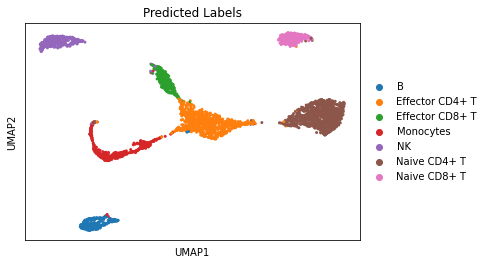

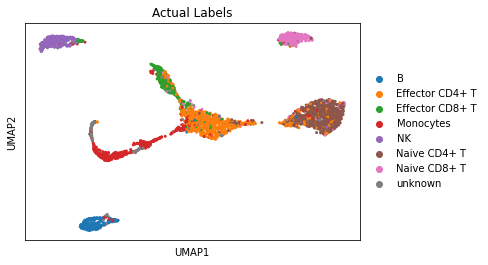

accuracy:0.8121, precision_macro:0.7228, precision_weighted:0.7751, recall_macro:0.7407, recall_weighted:0.8121, f1_macro:0.7297, f1_weighted:0.7909, ARI:0.6493, NMI:0.6752, jaccard:0.6345, fm:0.7105, v_measure:0.6752, purity:0.8121


{'accuracy': 0.8120689655172414,
 'precision_macro': 0.722785827830914,
 'precision_weighted': 0.7750820385303824,
 'recall_macro': 0.7406886632104663,
 'recall_weighted': 0.8120689655172414,
 'f1_macro': 0.7296997859271228,
 'f1_weighted': 0.7908586720538779,
 'ARI': 0.6492644667537171,
 'NMI': 0.6751781793922697,
 'jaccard': 0.6345044228089654,
 'fm': 0.7104511931305441,
 'v_measure': 0.6751781793922697,
 'purity': 0.8120689655172414}

In [11]:
# Final Evaluation
predictions, scores, actuals, zs, zys, batchs, exps, barcodes, elbo_loss, metrics = evaluate(atac_test_loader, cara, loss_basic)


testadata = data['ATACCE_test'][barcodes, :].copy()
testadata.obsm["embedding"] = zys
testadata.obsm['prob'] = scores
testadata.obsm['elbo_loss'] = elbo_loss

# UMAP Visualization
sc.pp.neighbors(testadata, use_rep="embedding", n_neighbors=30)
sc.tl.umap(testadata, min_dist=0.3)

# Map predictions to names
testadata.obs['predictions'] = map_indices_to_names([index[0] for index in predictions], index_to_category)

# Plot Predictions
sc.pl.umap(testadata, color=['predictions'], show=False, title="Predicted Labels")
outputfig1 = os.path.join(Config.OUTPUT_PATH, f"{Config.PREFIX}_predict_label.pdf")
plt.savefig(outputfig1, format="pdf")
plt.show()

# Plot Actual Labels
sc.pl.umap(testadata, color=['cell_type'], show=False, title="Actual Labels")
outputfig2 = os.path.join(Config.OUTPUT_PATH, f"{Config.PREFIX}_actual_label.pdf")
plt.savefig(outputfig2, format="pdf")
plt.show()

# Compute Metrics
groundtruth = testadata.obs['cell_type']
originalcell = testadata.obs['predictions']
compute_metrics(groundtruth, originalcell)

# Novel Cell Type Dectection

MSP Voting: 11 cells marked as novel cells (Threshold: 0.4)
Entropy Threshold (based on 0.8 quantile): 0.0040
Entropy Voting: 696 cells marked as novel cells
ELBO Threshold (based on 0.5 quantile): 5624.1990
ELBO Voting: 1740 cells marked as novel cells
Total novel cells: 2070/3480 (59.48%)
Identified 1 novel clusters: ['17']

Cluster Analysis Results:
Cluster 0: 317 cells, 176 novel cells, proportion: 0.555 (Normal)
Cluster 1: 263 cells, 169 novel cells, proportion: 0.643 (Normal)
Cluster 2: 238 cells, 138 novel cells, proportion: 0.580 (Normal)
Cluster 3: 229 cells, 183 novel cells, proportion: 0.799 (Normal)
Cluster 4: 227 cells, 181 novel cells, proportion: 0.797 (Normal)
Cluster 5: 225 cells, 93 novel cells, proportion: 0.413 (Normal)
Cluster 6: 224 cells, 118 novel cells, proportion: 0.527 (Normal)
Cluster 7: 213 cells, 105 novel cells, proportion: 0.493 (Normal)
Cluster 8: 189 cells, 90 novel cells, proportion: 0.476 (Normal)
Cluster 9: 172 cells, 90 novel cells, proportion: 0.5

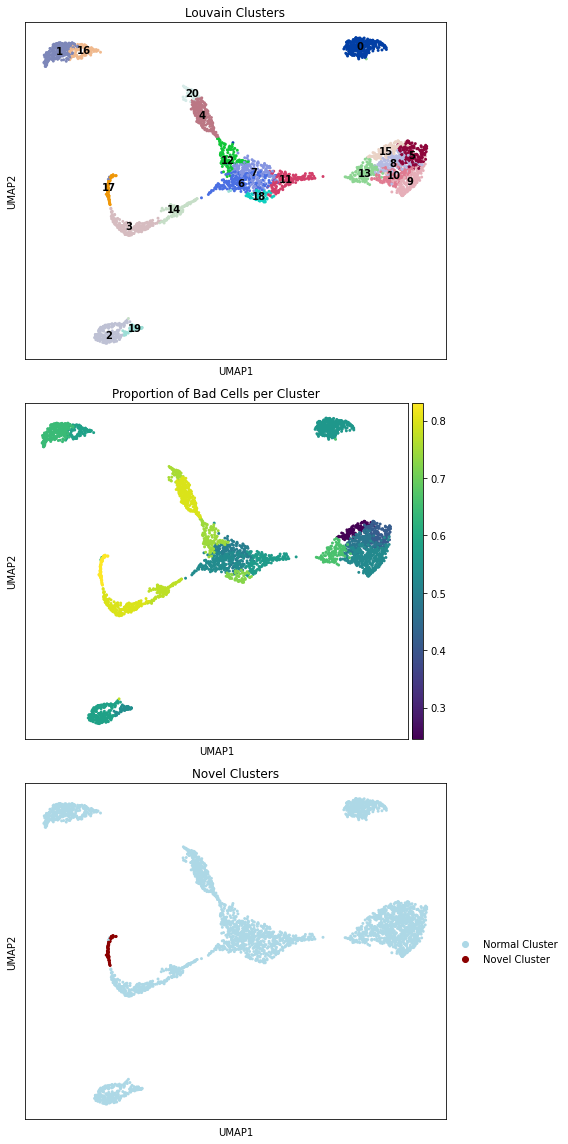

In [12]:

cluster_results = novel_cluster_detection(
    testadata, 
    resolution=2,
    msp_threshold=0.4,       
    entropy_quantile=0.8,     
    elbo_quantile=0.5,        
    ood_proportion_threshold=0.8 
)

In [15]:
print(f"Before update, value distribution of '{'predictions'}' column:\n", testadata.obs['predictions'].value_counts()) 
testadata = label_novel_cells_as_unknown(testadata, cell_type_key='predictions') 
print(f"\nAfter update, value distribution of '{'predictions'}' column:\n", testadata.obs['predictions'].value_counts())   


Before update, value distribution of 'predictions' column:
 Naive CD4+ T       1000
Effector CD4+ T     794
Monocytes           410
NK                  380
Naive CD8+ T        312
B                   297
Effector CD8+ T     287
Name: predictions, dtype: int64

--- Step 4: Labeling cells in novel clusters as 'unknown' (in 'predictions' column) ---
Updated cell type to 'unknown' for 77 cells.

After update, value distribution of 'predictions' column:
 Naive CD4+ T       997
Effector CD4+ T    790
NK                 379
Monocytes          343
Naive CD8+ T       312
B                  297
Effector CD8+ T    285
unknown             77
Name: predictions, dtype: int64


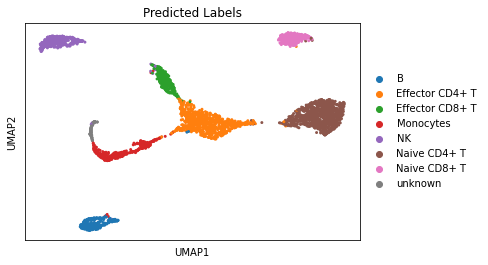

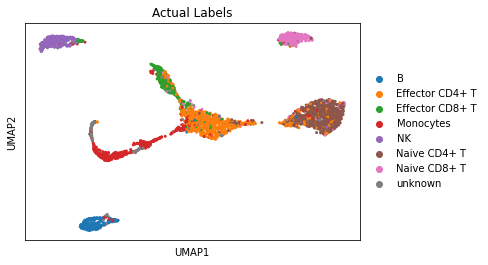

accuracy:0.8270, precision_macro:0.8422, precision_weighted:0.8314, recall_macro:0.7869, recall_weighted:0.8270, f1_macro:0.8013, f1_weighted:0.8210, ARI:0.6554, NMI:0.6784, jaccard:0.6865, fm:0.7142, v_measure:0.6784, purity:0.8270


{'accuracy': 0.8270114942528736,
 'precision_macro': 0.8422395031399921,
 'precision_weighted': 0.8313619587599095,
 'recall_macro': 0.7868719276353385,
 'recall_weighted': 0.8270114942528736,
 'f1_macro': 0.8012564940386284,
 'f1_weighted': 0.8210380895574165,
 'ARI': 0.6553646934201095,
 'NMI': 0.6783995584394376,
 'jaccard': 0.6864519200609784,
 'fm': 0.7141706530665877,
 'v_measure': 0.6783995584394374,
 'purity': 0.8270114942528736}

In [16]:
# Plot Predictions
sc.pl.umap(testadata, color=['predictions'], show=False, title="Predicted Labels")
outputfig1 = os.path.join(Config.OUTPUT_PATH, f"{Config.PREFIX}_predict_label.pdf")
# plt.savefig(outputfig1, format="pdf")
plt.show()

# Plot Actual Labels
sc.pl.umap(testadata, color=['cell_type'], show=False, title="Actual Labels")
outputfig2 = os.path.join(Config.OUTPUT_PATH, f"{Config.PREFIX}_actual_label.pdf")
# plt.savefig(outputfig2, format="pdf")
plt.show()

# Compute Metrics
groundtruth = testadata.obs['cell_type']
originalcell = testadata.obs['predictions']
compute_metrics(groundtruth, originalcell)